In [1]:
!python -m pip install tqdm nb-black

You should consider upgrading via the '/Users/senosam/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
pip install statannot

You should consider upgrading via the '/Users/senosam/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import base64
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import shap
from statannot import add_stat_annotation

In [4]:
df = pd.read_csv("../data/processed/MVA_cleaned_merged.csv")

In [5]:
pd.options.display.max_columns = 100
df.head()

,Behavioral Crisis Num,CAD Event ID,Disposition,Exhibiting Behavior (group),Subject Age,Techniques Used,UoF Indicator,Weapons Involved,Reported Date,Officer Serial Num,As_On_Officer Precinct_Desc,Call Priority Code,GO Num,First Dispatch Time,Total Service Time,Precinct,Sector,Beat,Blurred_Latitude,Blurred_Longitude,Year,First Dispatch Year,First Dispatch Month,First Dispatch Weekday,First Dispatch Hour,Clear Year,Clear Month,Clear Weekday,Clear Hour,CIT Certified Ind,Incident Type,Officer Gender,Officer Race,Subject Gender,Subject Race
0,43653,20150000159907,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-15,7654.0,WEST PCT,1.0,2.015000e+13,2015-05-15 19:51:43,24.0,WEST,KING,K3,-1.000000,-1.0000,2015.0,2015.0,5.0,4.0,19.0,2015.0,5.0,4.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,43653,20150000159907,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-15,7789.0,WEST PCT,1.0,2.015000e+13,2015-05-15 19:51:43,3.0,WEST,KING,K3,-1.000000,-1.0000,2015.0,2015.0,5.0,4.0,19.0,2015.0,5.0,4.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2,43719,20150000160408,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-16,7692.0,NORTH PCT,1.0,2.015000e+13,2015-05-16 03:31:04,25.0,NORTH,JOHN,J1,47.691343,-122.3714,2015.0,2015.0,5.0,5.0,3.0,2015.0,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,43719,20150000160408,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-16,7787.0,TRAINING AND EDUCATION SECTION,1.0,2.015000e+13,2015-05-16 03:31:04,16.0,NORTH,JOHN,J1,47.691343,-122.3714,2015.0,2015.0,5.0,5.0,3.0,2015.0,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
4,43719,20150000160408,NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT,-,-1,-,NO,-,2015-05-16,7568.0,NORTH PCT,1.0,2.015000e+13,2015-05-16 03:31:04,16.0,NORTH,JOHN,J1,47.691343,-122.3714,2015.0,2015.0,5.0,5.0,3.0,2015.0,5.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Select relevant variables
df_model = df[['Behavioral Crisis Num', 'CAD Event ID', 'Officer Serial Num', #IDs to check for duplicates
    'UoF Indicator', # response variable
    'Disposition', 'Exhibiting Behavior (group)', 'Subject Age', 
    'Subject Gender', 'Subject Race', 'Techniques Used', 'Weapons Involved',
    'Call Priority Code', 'Total Service Time', 'Blurred_Latitude', 
    'Blurred_Longitude', 
    #'First Dispatch Month', 'First Dispatch Weekday', 'First Dispatch Hour',
    'CIT Certified Ind',
    #'Incident Type', 
    'Officer Gender', 'Officer Race']].reset_index(drop=True)

In [7]:
# Editing column names
df_model.rename(columns={"Blurred_Latitude": "Latitude", 
                         "Blurred_Longitude":"Longitude",
                         "Exhibiting Behavior (group)":"Exhibiting Behavior"}, inplace=True)
df_model.columns = df_model.columns.str.replace(' ', '_')
df_model.columns

Index(['Behavioral_Crisis_Num', 'CAD_Event_ID', 'Officer_Serial_Num',
       'UoF_Indicator', 'Disposition', 'Exhibiting_Behavior', 'Subject_Age',
       'Subject_Gender', 'Subject_Race', 'Techniques_Used', 'Weapons_Involved',
       'Call_Priority_Code', 'Total_Service_Time', 'Latitude', 'Longitude',
       'CIT_Certified_Ind', 'Officer_Gender', 'Officer_Race'],
      dtype='object')

In [8]:
# Drop duplicates considering new selected features
df_model.drop_duplicates(subset=df_model.columns, inplace=True)

In [9]:
# Replacing missing values for NaN
#df_model.replace({'-': np.nan}, inplace=True)
df_model.replace({-1: np.nan}, inplace=True)

In [10]:
#Check on the % of null values
df_model.isnull().sum()*100/df_model.shape[0]

Behavioral_Crisis_Num     0.000000
CAD_Event_ID              0.000000
Officer_Serial_Num        3.940038
UoF_Indicator             0.000000
Disposition               0.000000
Exhibiting_Behavior       0.000000
Subject_Age              43.666452
Subject_Gender           98.470670
Subject_Race             98.470670
Techniques_Used           0.000000
Weapons_Involved          0.000000
Call_Priority_Code        3.944742
Total_Service_Time        3.940038
Latitude                  6.219039
Longitude                 6.219039
CIT_Certified_Ind        98.470670
Officer_Gender           98.470670
Officer_Race             98.470670
dtype: float64

In [11]:
df_model['CIT_Certified_Ind'].value_counts()

Y    2883
N    2319
Name: CIT_Certified_Ind, dtype: int64

In [12]:
# Drop NaN for CIT_Certified_Ind
#df_model.dropna(inplace = True)
df_model.dropna(subset=['CIT_Certified_Ind'], inplace = True)
df_model.shape

(5202, 18)

In [13]:
#Check on the % of null values
df_model.isnull().sum()*100/df_model.shape[0]

Behavioral_Crisis_Num     0.000000
CAD_Event_ID              0.000000
Officer_Serial_Num        0.000000
UoF_Indicator             0.000000
Disposition               0.000000
Exhibiting_Behavior       0.000000
Subject_Age              35.563245
Subject_Gender            0.000000
Subject_Race              0.000000
Techniques_Used           0.000000
Weapons_Involved          0.000000
Call_Priority_Code        0.000000
Total_Service_Time        0.000000
Latitude                  2.364475
Longitude                 2.364475
CIT_Certified_Ind         0.000000
Officer_Gender            0.000000
Officer_Race              0.000000
dtype: float64

In [14]:
df_model.head()

,Behavioral_Crisis_Num,CAD_Event_ID,Officer_Serial_Num,UoF_Indicator,Disposition,Exhibiting_Behavior,Subject_Age,Subject_Gender,Subject_Race,Techniques_Used,Weapons_Involved,Call_Priority_Code,Total_Service_Time,Latitude,Longitude,CIT_Certified_Ind,Officer_Gender,Officer_Race
65,45345.0,2.015000e+13,7787.0,YES,ARRESTED,-,NaN,M,Black or African American,-,-,2.0,51.0,47.708106,-122.317846,N,M,White
336,49408.0,2.015000e+13,5987.0,YES,ARRESTED,-,NaN,M,Black or African American,-,-,1.0,3.0,47.725511,-122.342300,N,M,White
829,59139.0,2.015000e+13,7580.0,YES,ARRESTED,-,NaN,M,Black or African American,-,-,2.0,19.0,47.689667,-122.376803,N,M,Hispanic or Latino
830,59139.0,2.015000e+13,7453.0,YES,ARRESTED,-,NaN,M,Black or African American,-,-,2.0,19.0,47.689667,-122.376803,N,M,White
2110,79547.0,2.015000e+13,7673.0,YES,EMERGENT DETENTION/ITA,-,NaN,F,White,-,-,1.0,3.0,47.604135,-122.338758,N,M,White


## Feature engineering 

In [15]:
df_model['Disposition'].value_counts()

ARRESTED                                                      3131
EMERGENT DETENTION/ITA                                        1877
NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT                  50
DMHP/REFERRAL (DCR)                                             35
-                                                               25
RESOURCES OFFERED/DECLINED                                      22
CHRONIC COMPLAINT                                               22
OTHER                                                           18
CSC/CDF (CRISIS SOLUTION CENTER/CRISIS DIVERSION FACILITY)       7
MENTAL HEALTH AGENCY OR CASE MANAGER NOTIFIED                    6
VOLUNTARY COMMITTAL                                              5
MOBILE CRISIS TEAM                                               3
CRISIS CLINIC                                                    1
Name: Disposition, dtype: int64

In [16]:
df_model.loc[df_model['Disposition'].isin(["NO ACTION POSSIBLE/NECESSARY/UNABLE TO CONTACT",
 "OTHER", "-", "RESOURCES OFFERED/DECLINED", 
 "CHRONIC COMPLAINT", "DMHP/REFERRAL (DCR)",
 "CSC/CDF (CRISIS SOLUTION CENTER/CRISIS DIVERSION FACILITY)", 
 "MENTAL HEALTH AGENCY OR CASE MANAGER NOTIFIED", 
 "VOLUNTARY COMMITTAL", "MOBILE CRISIS TEAM",
 "CRISIS CLINIC"]), 'Disposition'] = "OTHER"

In [17]:
df_model['Disposition'].value_counts()

ARRESTED                  3131
EMERGENT DETENTION/ITA    1877
OTHER                      194
Name: Disposition, dtype: int64

In [18]:
df_model['Exhibiting_Behavior'].value_counts()

DISORDERLY/DISRUPTIVE                1659
BELLIGERENT/UNCOOPERATIVE             997
NEGLECT/SELF CARE                     406
OUT OF TOUCH WITH REALITY             308
SUICIDE THREAT/ATTEMPT                276
PHYSICALLY THREATENING/AGGRESSIVE     183
PARANOID                              162
DISORGANIZED SPEECH/COMMUNICATION     150
-                                     147
HALLUCINATIONS/DELUSIONS              146
OTHER                                 144
VERBALLY THREATENING/AGGRESSIVE       133
BIZARRE/UNUSUAL                       133
UNUSUALLY FRIGHTENED/SCARED            91
DISORIENTATION/CONFUSION               70
SUICIDE BY COP (SBC)                   69
MANIC                                  67
HOPELESS/DEPRESSED                     61
Name: Exhibiting_Behavior, dtype: int64

In [19]:
df_model.loc[df_model['Exhibiting_Behavior'].isin(["DISORGANIZED SPEECH/COMMUNICATION",
    "OUT OF TOUCH WITH REALITY", "HOPELESS/DEPRESSED",
    "MANIC", "HALLUCINATIONS/DELUSIONS", "PARANOID",
    "DISORIENTATION/CONFUSION","UNUSUALLY FRIGHTENED/SCARED"]), 'Exhibiting_Behavior'] = "MENTAL CRISIS"
df_model.loc[df_model['Exhibiting_Behavior'].isin(["NEGLECT/SELF CARE", 
    "SUICIDE THREAT/ATTEMPT", "SUICIDE BY COP (SBC)"]), 'Exhibiting_Behavior'] = "SELF-THREATENING"
df_model.loc[df_model['Exhibiting_Behavior'].isin([
    "PHYSICALLY THREATENING/AGGRESSIVE", 
    "VERBALLY THREATENING/AGGRESSIVE"]), 'Exhibiting_Behavior'] = "THREATENING/AGGRESSIVE"
df_model.loc[df_model['Exhibiting_Behavior'].isin([
    "OTHER", "-", "BIZARRE/UNUSUAL"]), 'Exhibiting_Behavior'] = "OTHER"

In [20]:
df_model['Exhibiting_Behavior'].value_counts()

DISORDERLY/DISRUPTIVE        1659
MENTAL CRISIS                1055
BELLIGERENT/UNCOOPERATIVE     997
SELF-THREATENING              751
OTHER                         424
THREATENING/AGGRESSIVE        316
Name: Exhibiting_Behavior, dtype: int64

In [21]:
df_model['Subject_Race'].value_counts()

White                            2544
Not Specified                    1296
Black or African American         964
Asian                             241
Hispanic or Latino                 80
American Indian/Alaska Native      66
Nat Hawaiian/Oth Pac Islander      11
Name: Subject_Race, dtype: int64

In [22]:
df_model.loc[df_model['Subject_Race'].isin([
    "American Indian/Alaska Native", "Nat Hawaiian/Oth Pac Islander"]), 'Subject_Race'] = "AIAN/HPI"

In [23]:
df_model['Subject_Race'].value_counts()

White                        2544
Not Specified                1296
Black or African American     964
Asian                         241
Hispanic or Latino             80
AIAN/HPI                       77
Name: Subject_Race, dtype: int64

In [24]:
df_model['Techniques_Used'].value_counts()

-                1740
HANDCUFFING      1398
VERBALIZATION    1149
GURNEY            911
NONE                4
Name: Techniques_Used, dtype: int64

In [25]:
df_model.loc[df_model['Techniques_Used'].isin([
    "NONE", "-"]), 'Techniques_Used'] = "OTHER"

In [26]:
df_model['Techniques_Used'].value_counts()

OTHER            1744
HANDCUFFING      1398
VERBALIZATION    1149
GURNEY            911
Name: Techniques_Used, dtype: int64

In [27]:
df_model['Weapons_Involved'].value_counts()

-                                       1740
NONE/NOT APPLICABLE                     1271
PERSONAL WEAPONS (HANDS, FEET, ETC.)    1070
KNIFE/CUTTING/STABBING INSTRUMENT        663
BLUNT OBJECT/STRIKING IMPLEMENT          316
TASER/STUN GUN                            71
FIREARM                                   59
MACE/PEPPER SPRAY                         12
Name: Weapons_Involved, dtype: int64

In [28]:
df_model.loc[df_model['Weapons_Involved'].isin([
    "-"]), 'Weapons_Involved'] = "OTHER"
df_model.loc[df_model['Weapons_Involved'].isin([
    "TASER/STUN GUN", "MACE/PEPPER SPRAY"]), 'Weapons_Involved'] = "PERSONAL DEFENSE WEAPONS"

In [29]:
df_model['Weapons_Involved'].value_counts()

OTHER                                   1740
NONE/NOT APPLICABLE                     1271
PERSONAL WEAPONS (HANDS, FEET, ETC.)    1070
KNIFE/CUTTING/STABBING INSTRUMENT        663
BLUNT OBJECT/STRIKING IMPLEMENT          316
PERSONAL DEFENSE WEAPONS                  83
FIREARM                                   59
Name: Weapons_Involved, dtype: int64

In [31]:
df_model['Officer_Race'].value_counts()

White                            3642
Two or More Races                 435
Asian                             340
Hispanic or Latino                318
Black or African American         262
Not Specified                     150
Nat Hawaiian/Oth Pac Islander      36
American Indian/Alaska Native      19
Name: Officer_Race, dtype: int64

In [32]:
df_model.loc[df_model['Officer_Race'].isin([
    "American Indian/Alaska Native", "Nat Hawaiian/Oth Pac Islander"]), 'Officer_Race'] = "AIAN/HPI"

In [33]:
df_model['Officer_Race'].value_counts()

White                        3642
Two or More Races             435
Asian                         340
Hispanic or Latino            318
Black or African American     262
Not Specified                 150
AIAN/HPI                       55
Name: Officer_Race, dtype: int64

In [34]:
# Drop ID cols
df_model.drop(["Behavioral_Crisis_Num", "CAD_Event_ID", "Officer_Serial_Num"], axis = 1, inplace=True)
df_model.head()

,UoF_Indicator,Disposition,Exhibiting_Behavior,Subject_Age,Subject_Gender,Subject_Race,Techniques_Used,Weapons_Involved,Call_Priority_Code,Total_Service_Time,Latitude,Longitude,CIT_Certified_Ind,Officer_Gender,Officer_Race
65,YES,ARRESTED,OTHER,NaN,M,Black or African American,OTHER,OTHER,2.0,51.0,47.708106,-122.317846,N,M,White
336,YES,ARRESTED,OTHER,NaN,M,Black or African American,OTHER,OTHER,1.0,3.0,47.725511,-122.342300,N,M,White
829,YES,ARRESTED,OTHER,NaN,M,Black or African American,OTHER,OTHER,2.0,19.0,47.689667,-122.376803,N,M,Hispanic or Latino
830,YES,ARRESTED,OTHER,NaN,M,Black or African American,OTHER,OTHER,2.0,19.0,47.689667,-122.376803,N,M,White
2110,YES,EMERGENT DETENTION/ITA,OTHER,NaN,F,White,OTHER,OTHER,1.0,3.0,47.604135,-122.338758,N,M,White


In [35]:
#Check on the % of null values
df_model.isnull().sum()*100/df_model.shape[0]

UoF_Indicator           0.000000
Disposition             0.000000
Exhibiting_Behavior     0.000000
Subject_Age            35.563245
Subject_Gender          0.000000
Subject_Race            0.000000
Techniques_Used         0.000000
Weapons_Involved        0.000000
Call_Priority_Code      0.000000
Total_Service_Time      0.000000
Latitude                2.364475
Longitude               2.364475
CIT_Certified_Ind       0.000000
Officer_Gender          0.000000
Officer_Race            0.000000
dtype: float64

In [36]:
# Remove subject Age and then remove missing values
df_model.drop(["Subject_Age"], axis = 1, inplace=True)
df_model.dropna(inplace = True)

In [37]:
#Check on the % of null values
df_model.isnull().sum()*100/df_model.shape[0]

UoF_Indicator          0.0
Disposition            0.0
Exhibiting_Behavior    0.0
Subject_Gender         0.0
Subject_Race           0.0
Techniques_Used        0.0
Weapons_Involved       0.0
Call_Priority_Code     0.0
Total_Service_Time     0.0
Latitude               0.0
Longitude              0.0
CIT_Certified_Ind      0.0
Officer_Gender         0.0
Officer_Race           0.0
dtype: float64

In [38]:
df_model.shape

(5079, 14)

## Apply One hot encoding to categorical variables

In [39]:
y = df_model['UoF_Indicator']
X = pd.get_dummies(df_model.loc[:,df_model.columns!='UoF_Indicator'])
X.head()

,Call_Priority_Code,Total_Service_Time,Latitude,Longitude,Disposition_ARRESTED,Disposition_EMERGENT DETENTION/ITA,Disposition_OTHER,Exhibiting_Behavior_BELLIGERENT/UNCOOPERATIVE,Exhibiting_Behavior_DISORDERLY/DISRUPTIVE,Exhibiting_Behavior_MENTAL CRISIS,Exhibiting_Behavior_OTHER,Exhibiting_Behavior_SELF-THREATENING,Exhibiting_Behavior_THREATENING/AGGRESSIVE,Subject_Gender_F,Subject_Gender_M,Subject_Gender_N,Subject_Race_AIAN/HPI,Subject_Race_Asian,Subject_Race_Black or African American,Subject_Race_Hispanic or Latino,Subject_Race_Not Specified,Subject_Race_White,Techniques_Used_GURNEY,Techniques_Used_HANDCUFFING,Techniques_Used_OTHER,Techniques_Used_VERBALIZATION,Weapons_Involved_BLUNT OBJECT/STRIKING IMPLEMENT,Weapons_Involved_FIREARM,Weapons_Involved_KNIFE/CUTTING/STABBING INSTRUMENT,Weapons_Involved_NONE/NOT APPLICABLE,Weapons_Involved_OTHER,Weapons_Involved_PERSONAL DEFENSE WEAPONS,"Weapons_Involved_PERSONAL WEAPONS (HANDS, FEET, ETC.)",CIT_Certified_Ind_N,CIT_Certified_Ind_Y,Officer_Gender_F,Officer_Gender_M,Officer_Race_AIAN/HPI,Officer_Race_Asian,Officer_Race_Black or African American,Officer_Race_Hispanic or Latino,Officer_Race_Not Specified,Officer_Race_Two or More Races,Officer_Race_White
65,2.0,51.0,47.708106,-122.317846,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
336,1.0,3.0,47.725511,-122.342300,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
829,2.0,19.0,47.689667,-122.376803,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
830,2.0,19.0,47.689667,-122.376803,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
2110,1.0,3.0,47.604135,-122.338758,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1


In [40]:
X.shape

(5079, 44)

In [41]:
# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

In [42]:
y_train.value_counts()

YES    3216
NO      339
Name: UoF_Indicator, dtype: int64

## EDA on numerical variables

In [43]:
df_train = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)

In [44]:
def boxplot_eda(df_train, response_var, feature_int):
    plt.figure(figsize=(6, 6))
    ax = sns.boxplot(x=response_var, y=feature_int, data=df_train)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment="right")
    ax.set_title(response_var)
    add_stat_annotation(ax, data=df_train, x=response_var, y=feature_int, order=['YES', 'NO'],
                        box_pairs=[("YES", "NO")],
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

YES v.s. NO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.647e-02 U_stat=5.769e+05


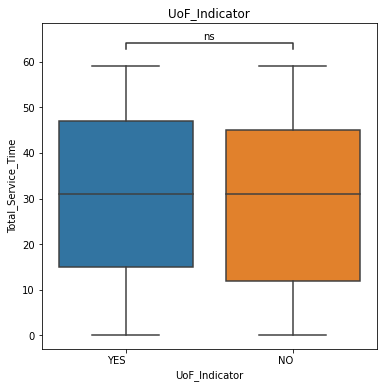

In [45]:
boxplot_eda(df_train, response_var = 'UoF_Indicator', feature_int="Total_Service_Time")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

YES v.s. NO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.931e-02 U_stat=5.766e+05


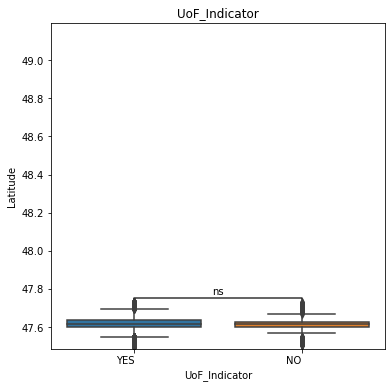

In [46]:
boxplot_eda(df_train, response_var = 'UoF_Indicator', feature_int="Latitude")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

YES v.s. NO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.161e-06 U_stat=4.624e+05


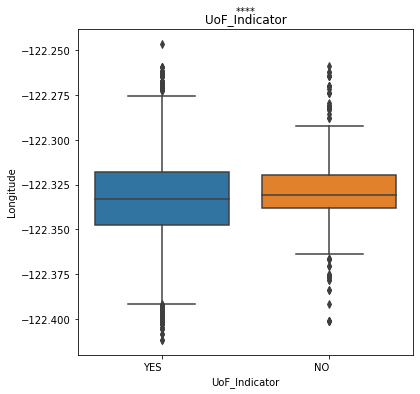

In [47]:
boxplot_eda(df_train, response_var = 'UoF_Indicator', feature_int="Longitude")

## EDA on categorical variables

In [48]:
#create contingency table
data = pd.crosstab(index=df_train['UoF_Indicator'], columns=df_train['Subject_Race_Black or African American']) #,  margins=True)
data

Subject_Race_Black or African American,0,1
UoF_Indicator,,
NO,222,117
YES,2685,531


In [77]:
df_train['UoF_Indicator'].value_counts()

YES    3216
NO      339
Name: UoF_Indicator, dtype: int64

In [49]:
# Chi-square
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data)
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 5.884335956572277e-16
Dependent (reject H0)


## Class rebalance

In [50]:
pip install imbalanced-learn

You should consider upgrading via the '/Users/senosam/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [51]:
from imblearn.over_sampling import SMOTE 
X_train_bf = X_train

sm = SMOTE(random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train_bf.shape}
Shape of X after SMOTE: {X_train.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train.value_counts(normalize=True) * 100

Shape of X before SMOTE: (3555, 44)
Shape of X after SMOTE: (6432, 44)

Balance of positive and negative classes (%):


YES    50.0
NO     50.0
Name: UoF_Indicator, dtype: float64

In [52]:
y_train.value_counts()

YES    3216
NO     3216
Name: UoF_Indicator, dtype: int64

In [53]:
X_train.shape

(6432, 44)

## Model training

In [54]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(random_state = 1)
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
bestF

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15, 25, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             verbose=1)

In [55]:
bestF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [66]:
# random forest model creation
rfc = RandomForestClassifier(random_state = 1, 
                             max_depth = 30,
                             n_estimators = 500, 
                             min_samples_split = 2, 
                             min_samples_leaf = 1)
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [67]:
# Evaluating performance
rfc_cv_score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='roc_auc')

In [68]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 113   60]
 [  14 1337]]


=== Classification Report ===
              precision    recall  f1-score   support

          NO       0.89      0.65      0.75       173
         YES       0.96      0.99      0.97      1351

    accuracy                           0.95      1524
   macro avg       0.92      0.82      0.86      1524
weighted avg       0.95      0.95      0.95      1524



=== All AUC Scores ===
[0.98414895 0.99869314 0.9999613  0.99998065 0.99900834 0.9999226
 0.99981618 0.99995163 0.99776997 0.99986455]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.997911732401386


In [69]:
rfc.classes_

array(['NO', 'YES'], dtype=object)

Text(0.5, 0, 'Random Forest Feature Importance')

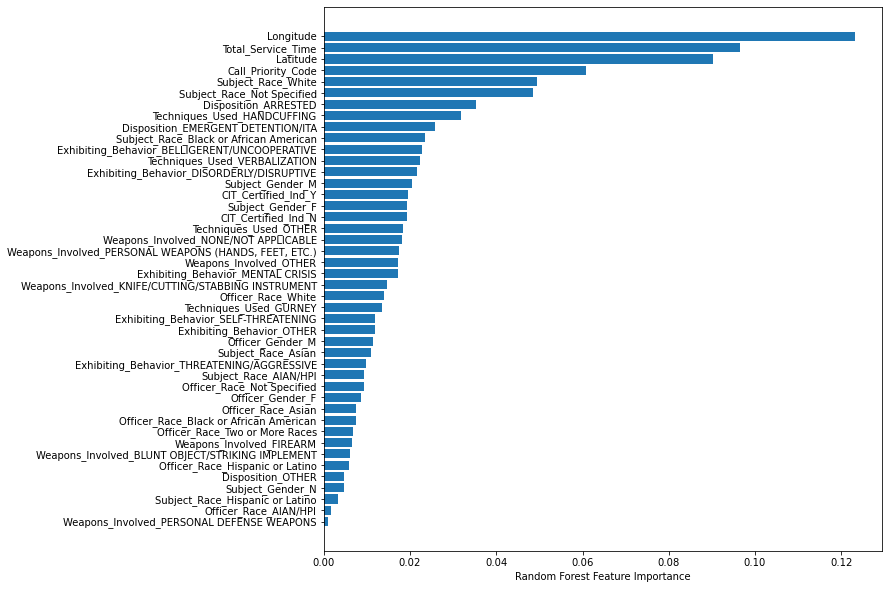

In [70]:
# Feature importance
plt.figure(figsize=(10, 10))
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Text(0.5, 0, 'Permutation Importance')

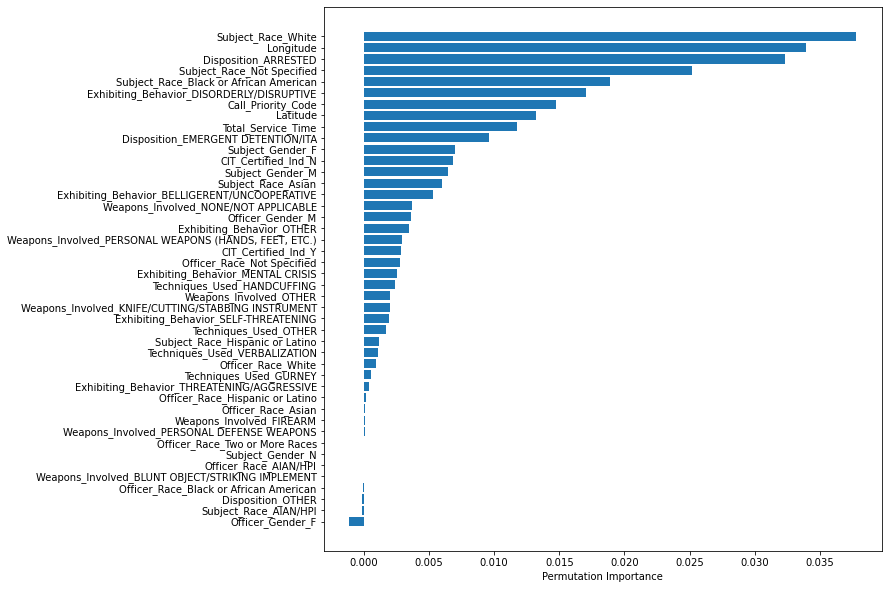

In [71]:
## Feature importance based on feature permutation
plt.figure(figsize=(10, 10))
perm_importance = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=6)
#forest_importances = pd.Series(result.importances_mean, index=X.columns)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [72]:
# plt.rcParams["figure.figsize"] = (20,10)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std[sorted_idx], ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

# # Feature importance
# ## impurity-based importance.
# importances = rfc.feature_importances_
# std = np.std([
#     tree.feature_importances_ for tree in rfc.estimators_], axis=0)
# forest_importances = pd.Series(importances, index=X.columns)
# plt.rcParams["figure.figsize"] = (20,10)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

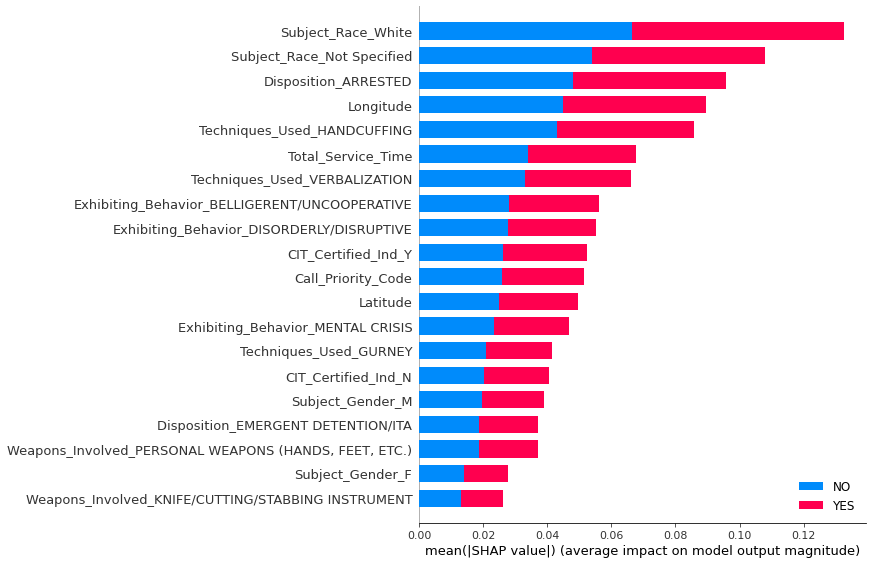

In [73]:
shap_values = shap.TreeExplainer(rfc).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=rfc.classes_)

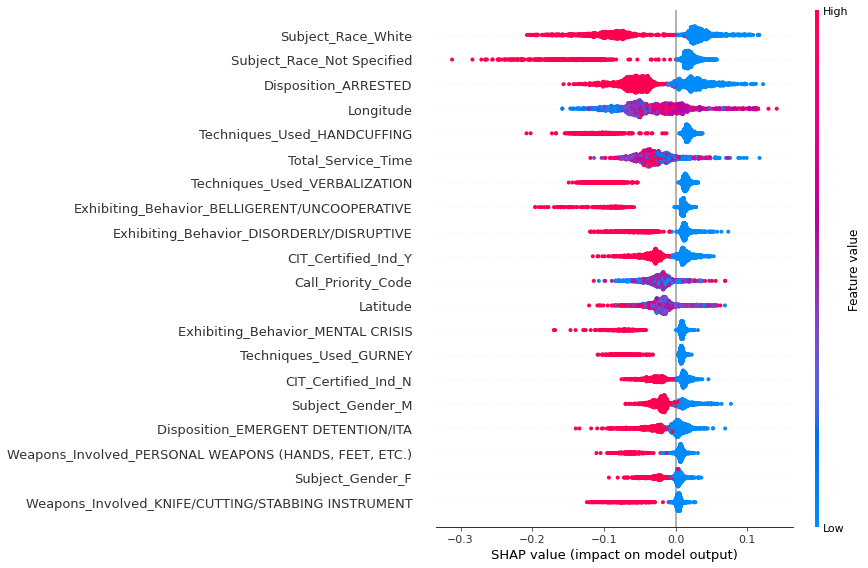

In [74]:
#YES
f = plt.figure()
shap.summary_plot(shap_values[0], X_test, class_names=rfc.classes_)

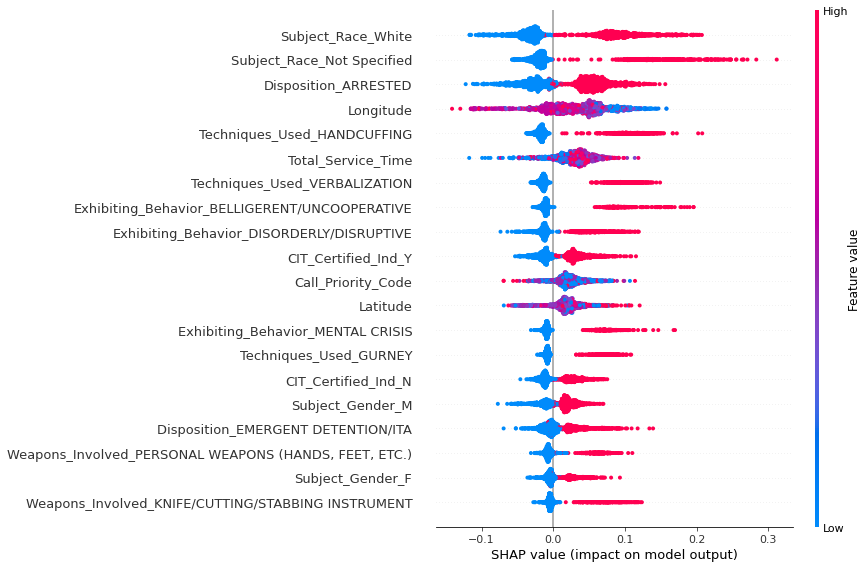

In [75]:
#NO
f = plt.figure()
shap.summary_plot(shap_values[1], X_test, class_names=rfc.classes_)